# Redes Neuronales Convolucionales (CNNs)

Las **redes convolucionales** están diseñadas para operar en datos que presentan algún tipo de secuencialidad, ya sea temporal o espacial. Además, su diseño está basado en la idea de reconocer patrones de pequeño tamaño con respecto al tamaño original de la muestra. Por ejemplo, para clasificar imágenes una *CNN* encontrará patrones de características distintivas de cada una de las clases: si queremos detectar patos, la red encontrará patrones en la imagen que se correspondan con los patos, como por ejemplo el pico y las plumas.

El funcionamiento de estas redes se basa en el concepto de convolución, que se realiza haciendo uso de un filtro o kernel, que se va desplazando por los valores de las muestras. Los valores de estos filtros kernel son parámetros de la red, por lo tanto no es necesario conocerlos de antemano pues se entrenarán junto con el resto de parámetros durante el proceso de ajuste del modelo. Las redes **CNN** se diseñan de manera que la red pueda aprender los filtros de imagen más apropiados para el *dataset* utilizado.

## Caso de estudio: MNIST (fácil)
Como primer caso de estudio vamos a entrenar una **CNN** para aprender a clasificar los dígitos manuscritos del conjunto de datos de MNIST, que está incluido en la librería *Tensorflow*. Sabemos que este conjunto de datos es muy sencillo de aprender, por lo que la CNN que diseñaremos será bastante simple.

En primer lugar cargamos el *dataset*:

In [34]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

import tensorflow as tf
import os
import datetime
from keras.datasets import mnist
from keras.utils import np_utils

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

num_train_samples = X_train.shape[0]
num_test_samples = y_test.shape[0]
image_height = X_train.shape[1]
image_width = X_train.shape[2]
print("X_train.shape: " + str(X_train.shape))
print("X_test.shape: " + str(X_test.shape))
print("y_train.shape: " + str(y_train.shape))
print("y_test.shape: " + str(y_test.shape))
print(f"Muestras de entrenamiento: {X_train.shape[0]}")
print(f"Muestras de validación: {y_test.shape[0]}")
print(f"Resolución: {X_train.shape[1]}x{X_train.shape[2]}")

X_train.shape: (60000, 28, 28)
X_test.shape: (10000, 28, 28)
y_train.shape: (60000,)
y_test.shape: (10000,)
Muestras de entrenamiento: 60000
Muestras de validación: 10000
Resolución: 28x28


Como vamos a utilizar la capa [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) de *Keras*, consultamos su documentación para ver el tamaño de entrada que espera y comprobamos que necesita un tensor $4+D$, así que reestructuramos el conjunto de datos. Hay que tener en cuenta que la última dimensión corresponde con el número de canales de la imagen, que en el caso de **MNIST** es 1 porque son en escala de grises.

In [35]:
import numpy as np
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

Las imágenes de **MNIST** tienen una resolución de 28x28 y un tipo de datos entero con el valor del píxel en el rango $[0\dots 255]$. Vamos a normalizar este valor al rango $[0.0\dots 1.0]$:

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Y por último, convertimos la variable objetivo para que sea un problema de clasificación aplicando *one-hot encoding*:

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print(f"Número de clases: {y_test.shape[1]}")

Una vez cargado el conjunto de datos, procedemos a diseñar nuestra red neuronal convolucional para clasificar los dígitos. Vamos a utilizar una arquitectura canónica de red convolucional, formada por las siguientes capas:

1. Una primera capa **convolucional `Conv2D`** para aprender 16 filtros distintos a partir de las imágenes. El tamaño de los filtros (kernel) será de 3x3 dado que las imágenes tienen una resolución muy pequeña.
2. Una capa de **agrupación `MaxPooling2D`** con un tamaño de *pooling* de 2x2 para reducir la dimensionalidad a la mitad.
3. Otra capa convolucional con los mismos parámetros, teniendo en cuenta que ahora la entrada es menor.
4. Una nueva capa de agrupación.
5. Una última capa convolucional.
6. Una capa de aplanamiento `Flatten` que convierte el tensor de orden 3 que sale de la capa convolucional anterior en un tensor unidimensional.
7. Una capa densa de 32 neuronas.
8. Una capa de salida de 10 neuronas, una para cada clase a predecir, con función de activación `softmax`.

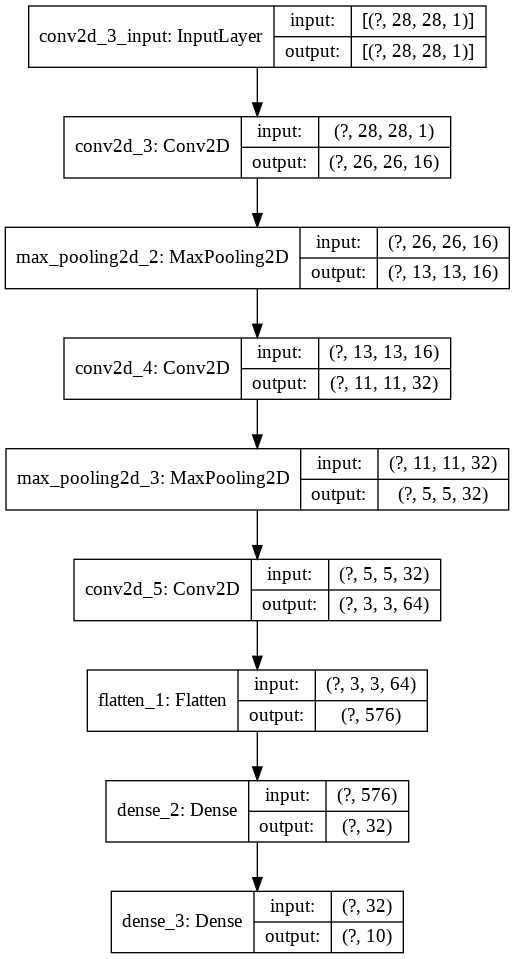

In [36]:
from keras.models import Sequential
from keras import layers
from keras.utils import plot_model

def create_cnn_mnist():
    model = Sequential()
    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(image_height,image_width,1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))  
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu')) 
    model.add(layers.Dense(10, activation='softmax'))
    return model
plot_model(create_cnn_mnist(), show_layer_names=True, show_shapes=True)

Ahora bastará con entrenar el modelo siguiento el procedimiento de entrenamiento de cualquier red neuronal:

In [37]:
import matplotlib.pyplot as plt
def plot_train_val(history, metric='loss', y_scale='linear'):
    plt.plot(history.history[metric], label=metric + ' (train)')
    plt.plot(history.history['val_' + metric], label=metric + ' (val)')
    plt.title(f'{metric} ({y_scale}-scale)')
    plt.xlabel('epoch')
    plt.legend(loc="upper right")
    plt.yscale(y_scale)
    plt.show()

In [ ]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    model_mnist = create_cnn_mnist()
    model_mnist.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    history = model_mnist.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=20, batch_size=128, verbose=1, callbacks=[tensorboard_callback])
plot_train_val(history)

In [ ]:
plot_train_val(history, metric='accuracy')

Podemos observar en la gráfica que la red está **sobreajustando**, ya que se observa la divergencia entre la función de coste en entrenamiento, que sigue descendiendo, con respecto a la función de coste en validación, que empieza a crecer, lo que nos indica que la red está fallando cada vez más al clasificar el conjunto de validación.

Para **reducir el overfitting** vamos a modificar nuestra CNN para reducir el número de capas de convolución además de añadir una capa de `Dropout`:

In [ ]:
def create_cnn_mnist_v2():
    model = Sequential()
    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(32, (3,3), activation='relu')) 
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu')) 
    model.add(layers.Dense(10, activation='softmax'))
    return model
plot_model(create_cnn_mnist_v2(), show_layer_names=True, show_shapes=True)

Hemos eliminado una capa convolucional y ajustado el número de neuronas de las dos restantes. Además, hemos añadido la capa de `Dropout` para que en cada iteración de entrenamiento haya algún filtro que no se utilize en la clasificación. Procedemos al entrenamiento y evaluación de la red:

In [ ]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    model_mnist_v2 = create_cnn_mnist_v2()
    model_mnist_v2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    history_v2 = model_mnist_v2.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=30, batch_size=128, verbose=0, callbacks=[tensorboard_callback])
plot_train_val(history_v2)

In [ ]:
from sklearn.metrics import classification_report

with tf.device('/device:GPU:0'):
    y_pred = np.argmax(model_mnist_v2.predict(X_test, batch_size=128, verbose=0), axis=-1)

print(classification_report(np.argmax(y_test, axis=1), y_pred))

## Caso de estudio: Fashion MNIST

Existe un conjunto de datos con la misma filosofía que MNIST, solo que en lugar de ser dígitos manuscritos se trata de fotografías de diferentes prendas de vestir. [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) ha sido publicado por la tienda de ropa *Zalando* como una mejora al clásico, alegando las siguientes razones:

- **MNIST** es demasiado fácil. Las redes convolucionales pueden alcanzar el 99,7% en **MNIST**. Los algoritmos clásicos de aprendizaje automático también pueden alcanzar el 97% fácilmente.
- **MNIST** está sobreutilizado.
- **MNIST** no puede representar las tareas modernas de **visión por computador**.

Cada muestra de entrenamiento y prueba se asigna a una de las siguientes etiquetas:

| Label | Description |
|-------|-------------|
|0 	    |T-shirt/top |
|1 	    |Trouser |
|2 	    |Pullover |
|3 	    |Dress |
|4 	    |Coat |
|5 	    |Sandal |
|6 	    |Shirt |
|7 	    |Sneaker |
|8 	    |Bag |
|9 	    |Ankle boot |

Vamos a cargar el *dataset* y dibujar en pantalla algunos ejemplos de las imágenes:

In [ ]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

num_train_images = X_train.shape[0]
num_test_images = X_test.shape[0]
image_height = X_train.shape[1]
image_width = X_train.shape [2]

print("Shape: " + str(X_train.shape))
print("Training images: " + str(num_train_images))
print("Image height: " + str(image_height))
print("Image width: " + str(image_width))

plt.imshow(X_train[2])
fig, axs = plt.subplots(1,12, figsize=(17,6))
for i in range(12):
    axs[i].imshow(X_train[i])
    axs[i].axis('off')

Vemos en las imágenes que los valores de los píxeles están sin normalizar, por lo que realizaremos el típico pre-procesamiento de reescalar al rango $[0\dots 1]$

In [ ]:
from keras.utils import np_utils

print("X_train.shape: " + str(X_train.shape))
print("X_test.shape: " + str(X_test.shape))
print("y_train.shape: " + str(y_train.shape))
print("y_test.shape: " + str(y_test.shape))

# Conv2D expects 4 dimmensions; the last one is the number of channels
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

X_train = X_train / 255.0
X_test = X_test / 255.0
    
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
print("categorical y_train shape: " + str(y_train.shape))
num_classes = y_test.shape[1]

Vamos a definir la función generadora del modelo. Usaremos un parámetro para indicar si queremos el modelo con capas `Dropout` o no, de forma que con la misma función generadora obtenemos distintos modelos.

In [ ]:
def create_fashion(dropout=False):
    model = Sequential()
    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=
                            (image_height,image_width,1)))
    if (dropout):
        model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    if (dropout):
        model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))  
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu')) 
    model.add(layers.Dense(num_classes, activation='softmax'))
  
    return model
plot_model(create_fashion(), show_layer_names=True, show_shapes=True)

Entrenamos y evaluamos, primero **sin capa `Dropout`**:

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    model_fashion = create_fashion()
    model_fashion.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    history_fashion = model_fashion.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=30, batch_size=128, verbose=0, callbacks=[tensorboard_callback])
plot_train_val(history_fashion)

In [ ]:
plot_train_val(history_fashion, metric='accuracy')

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

with tf.device('/device:GPU:0'):
    y_pred = np.argmax(model_fashion.predict(X_test, batch_size=128, verbose=0), axis=-1)

print(classification_report(np.argmax(y_test, axis=1), y_pred))

Evaluamos la variante de la arquitectura **con capas `Dropout`**:

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    model_fashion_drop = create_fashion(True)
    model_fashion_drop.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    history_fashion_drop = model_fashion_drop.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=20, batch_size=128, verbose=0, callbacks=[tensorboard_callback])
plot_train_val(history_fashion_drop)

In [ ]:
plot_train_val(history_fashion_drop, metric='accuracy')

In [ ]:
with tf.device('/device:GPU:0'):
    y_pred = np.argmax(model_fashion_drop.predict(X_test, batch_size=128, verbose=0), axis=-1)

print(classification_report(np.argmax(y_test, axis=1), y_pred))

## Caso de estudio: CIFAR-100

Vamos a trabajar con un conjunto de datos de mayor dificultad: [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto de datos cuenta con 60000 imágenes de 32x32 píxeles de resolución. Además, las imágenes son en color, por lo que tienen 3 canales. El conjunto de datos está disponible en el catálogo de **Tensorflow**, por lo que la carga del mismo se realiza de forma similar a MNIST:

In [38]:
from keras.datasets import cifar100
from keras.utils import np_utils

(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

num_train_samples = X_train.shape[0]
num_test_samples = y_test.shape[0]
image_height = X_train.shape[1]
image_width = X_train.shape[2]
num_channels = X_train.shape[3]
print("X_train.shape: " + str(X_train.shape))
print("X_test.shape: " + str(X_test.shape))
print("y_train.shape: " + str(y_train.shape))
print("y_test.shape: " + str(y_test.shape))
print(f"Muestras de entrenamiento: {X_train.shape[0]}")
print(f"Muestras de validación: {y_test.shape[0]}")
print(f"Resolución: {X_train.shape[1]}x{X_train.shape[2]}")
print(f"Número de canales: {num_channels}")

X_train.shape: (50000, 32, 32, 3)
X_test.shape: (10000, 32, 32, 3)
y_train.shape: (50000, 1)
y_test.shape: (10000, 1)
Muestras de entrenamiento: 50000
Muestras de validación: 10000
Resolución: 32x32
Número de canales: 3


Aplicamos una transformación a los píxeles para dejar sus valores en `float32` en el rango $[0\dots1]$. También convertimos la variable objetivo en salida múltiple con *one-hot encoding*.

In [39]:
X_train = X_train / 255.0   # values [0..1] improve results
X_test = X_test / 255.0
    
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print("y_train shape: " + str(y_train.shape))
num_classes = y_test.shape[1]
print("Número de clases: " + str(num_classes))

y_train shape: (50000, 100)
Número de clases: 100


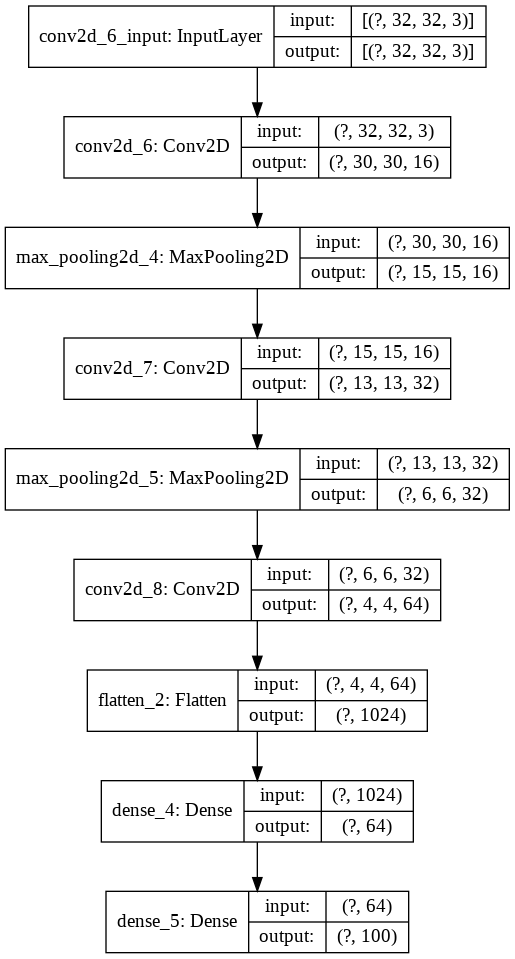

In [40]:
def create_cnn_cifar():
    model = Sequential()
    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(image_height,image_width,num_channels)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))  
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu')) 
    model.add(layers.Dense(100, activation='softmax'))
    return model
plot_model(create_cnn_cifar(), show_layer_names=True, show_shapes=True)

Podemos observar que el modelo planteado cuenta con tres capas convolucionales seguida de una capa oculta densa y la capa de salida con 100 neuronas, tantas como categorías tiene el conjunto de datos. Procedemos a su entrenamiento y evaluación:

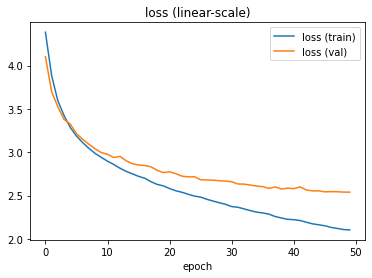

In [43]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    model_cifar = create_cnn_cifar()
    model_cifar.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history_cifar = model_cifar.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=50, batch_size=512, verbose=0, callbacks=[tensorboard_callback])
plot_train_val(history_cifar)

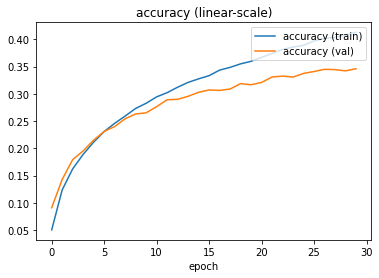

In [42]:
plot_train_val(history_cifar, metric='accuracy')

In [44]:
from sklearn.metrics import classification_report
import numpy as np

with tf.device('/device:GPU:0'):
    y_pred = np.argmax(model_cifar.predict(X_test, batch_size=512, verbose=0), axis=-1)

print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.64      0.72      0.68       100
           1       0.36      0.65      0.46       100
           2       0.27      0.33      0.30       100
           3       0.22      0.15      0.18       100
           4       0.20      0.33      0.25       100
           5       0.27      0.23      0.25       100
           6       0.40      0.40      0.40       100
           7       0.35      0.33      0.34       100
           8       0.45      0.49      0.47       100
           9       0.45      0.56      0.50       100
          10       0.19      0.14      0.16       100
          11       0.41      0.15      0.22       100
          12       0.42      0.36      0.39       100
          13       0.29      0.27      0.28       100
          14       0.36      0.31      0.33       100
          15       0.24      0.26      0.25       100
          16       0.26      0.35      0.30       100
          17       0.54    

Podemos observar que existe algo de overfitting. Vamos a mejorar el modelo aumentando la capacidad de la red anterior en cuanto al número de filtros y también en cuanto al número de neuronas en la capa oculta de clasificación. Además se añadirá una capa de regularización Dropout para disminuir el overfitting que producirá el uso de una CNN con mayor capacidad de procesamiento.

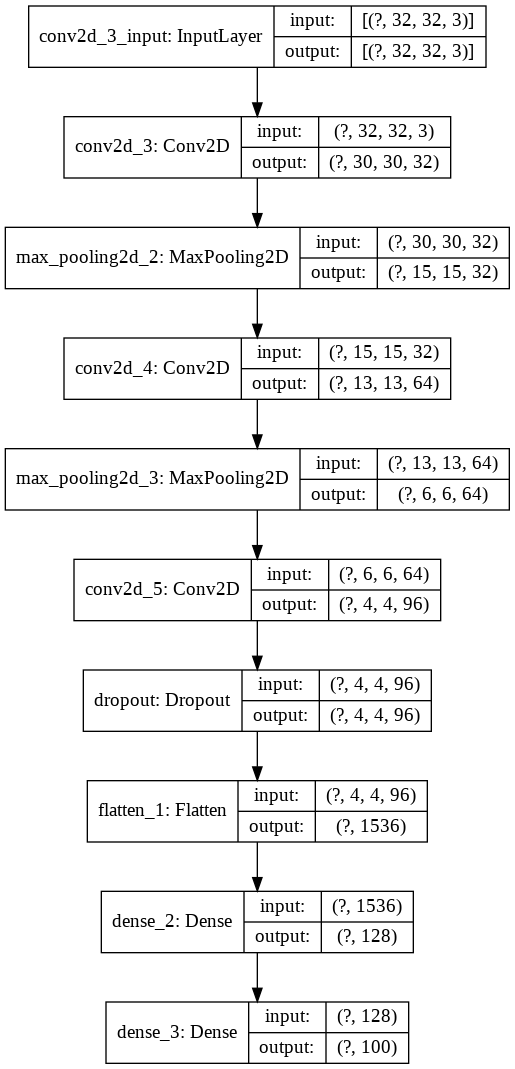

In [45]:
def create_cnn_cifar_v2():
    model = Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_height,image_width,num_channels)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(96, (3,3), activation='relu'))  
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu')) 
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model
plot_model(create_cnn_cifar_v2(), show_layer_names=True, show_shapes=True)

Analicemos cómo se comporta con respecto al **overfitting** así como a la calidad de la clasificación de las imágenes.

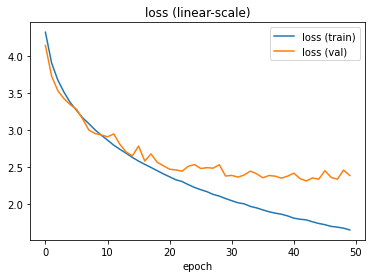

In [48]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    model_cifar_v2 = create_cnn_cifar_v2()
    model_cifar_v2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    history_cifar_v2 = model_cifar_v2.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=50, batch_size=512, verbose=0, callbacks=[tensorboard_callback])
plot_train_val(history_cifar_v2)

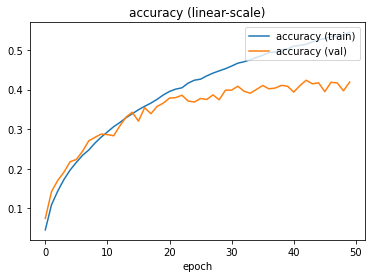

In [49]:
plot_train_val(history_cifar_v2, metric='accuracy')

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

with tf.device('/device:GPU:0'):
    y_pred = np.argmax(model_cifar_v2.predict(X_test, batch_size=512, verbose=0), axis=-1)

print(classification_report(np.argmax(y_test, axis=1), y_pred))

---

Creado por **Raúl Lara Cabrera** (raul.lara@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">